100%|██████████| 10/10 [00:00<00:00, 22.19it/s]


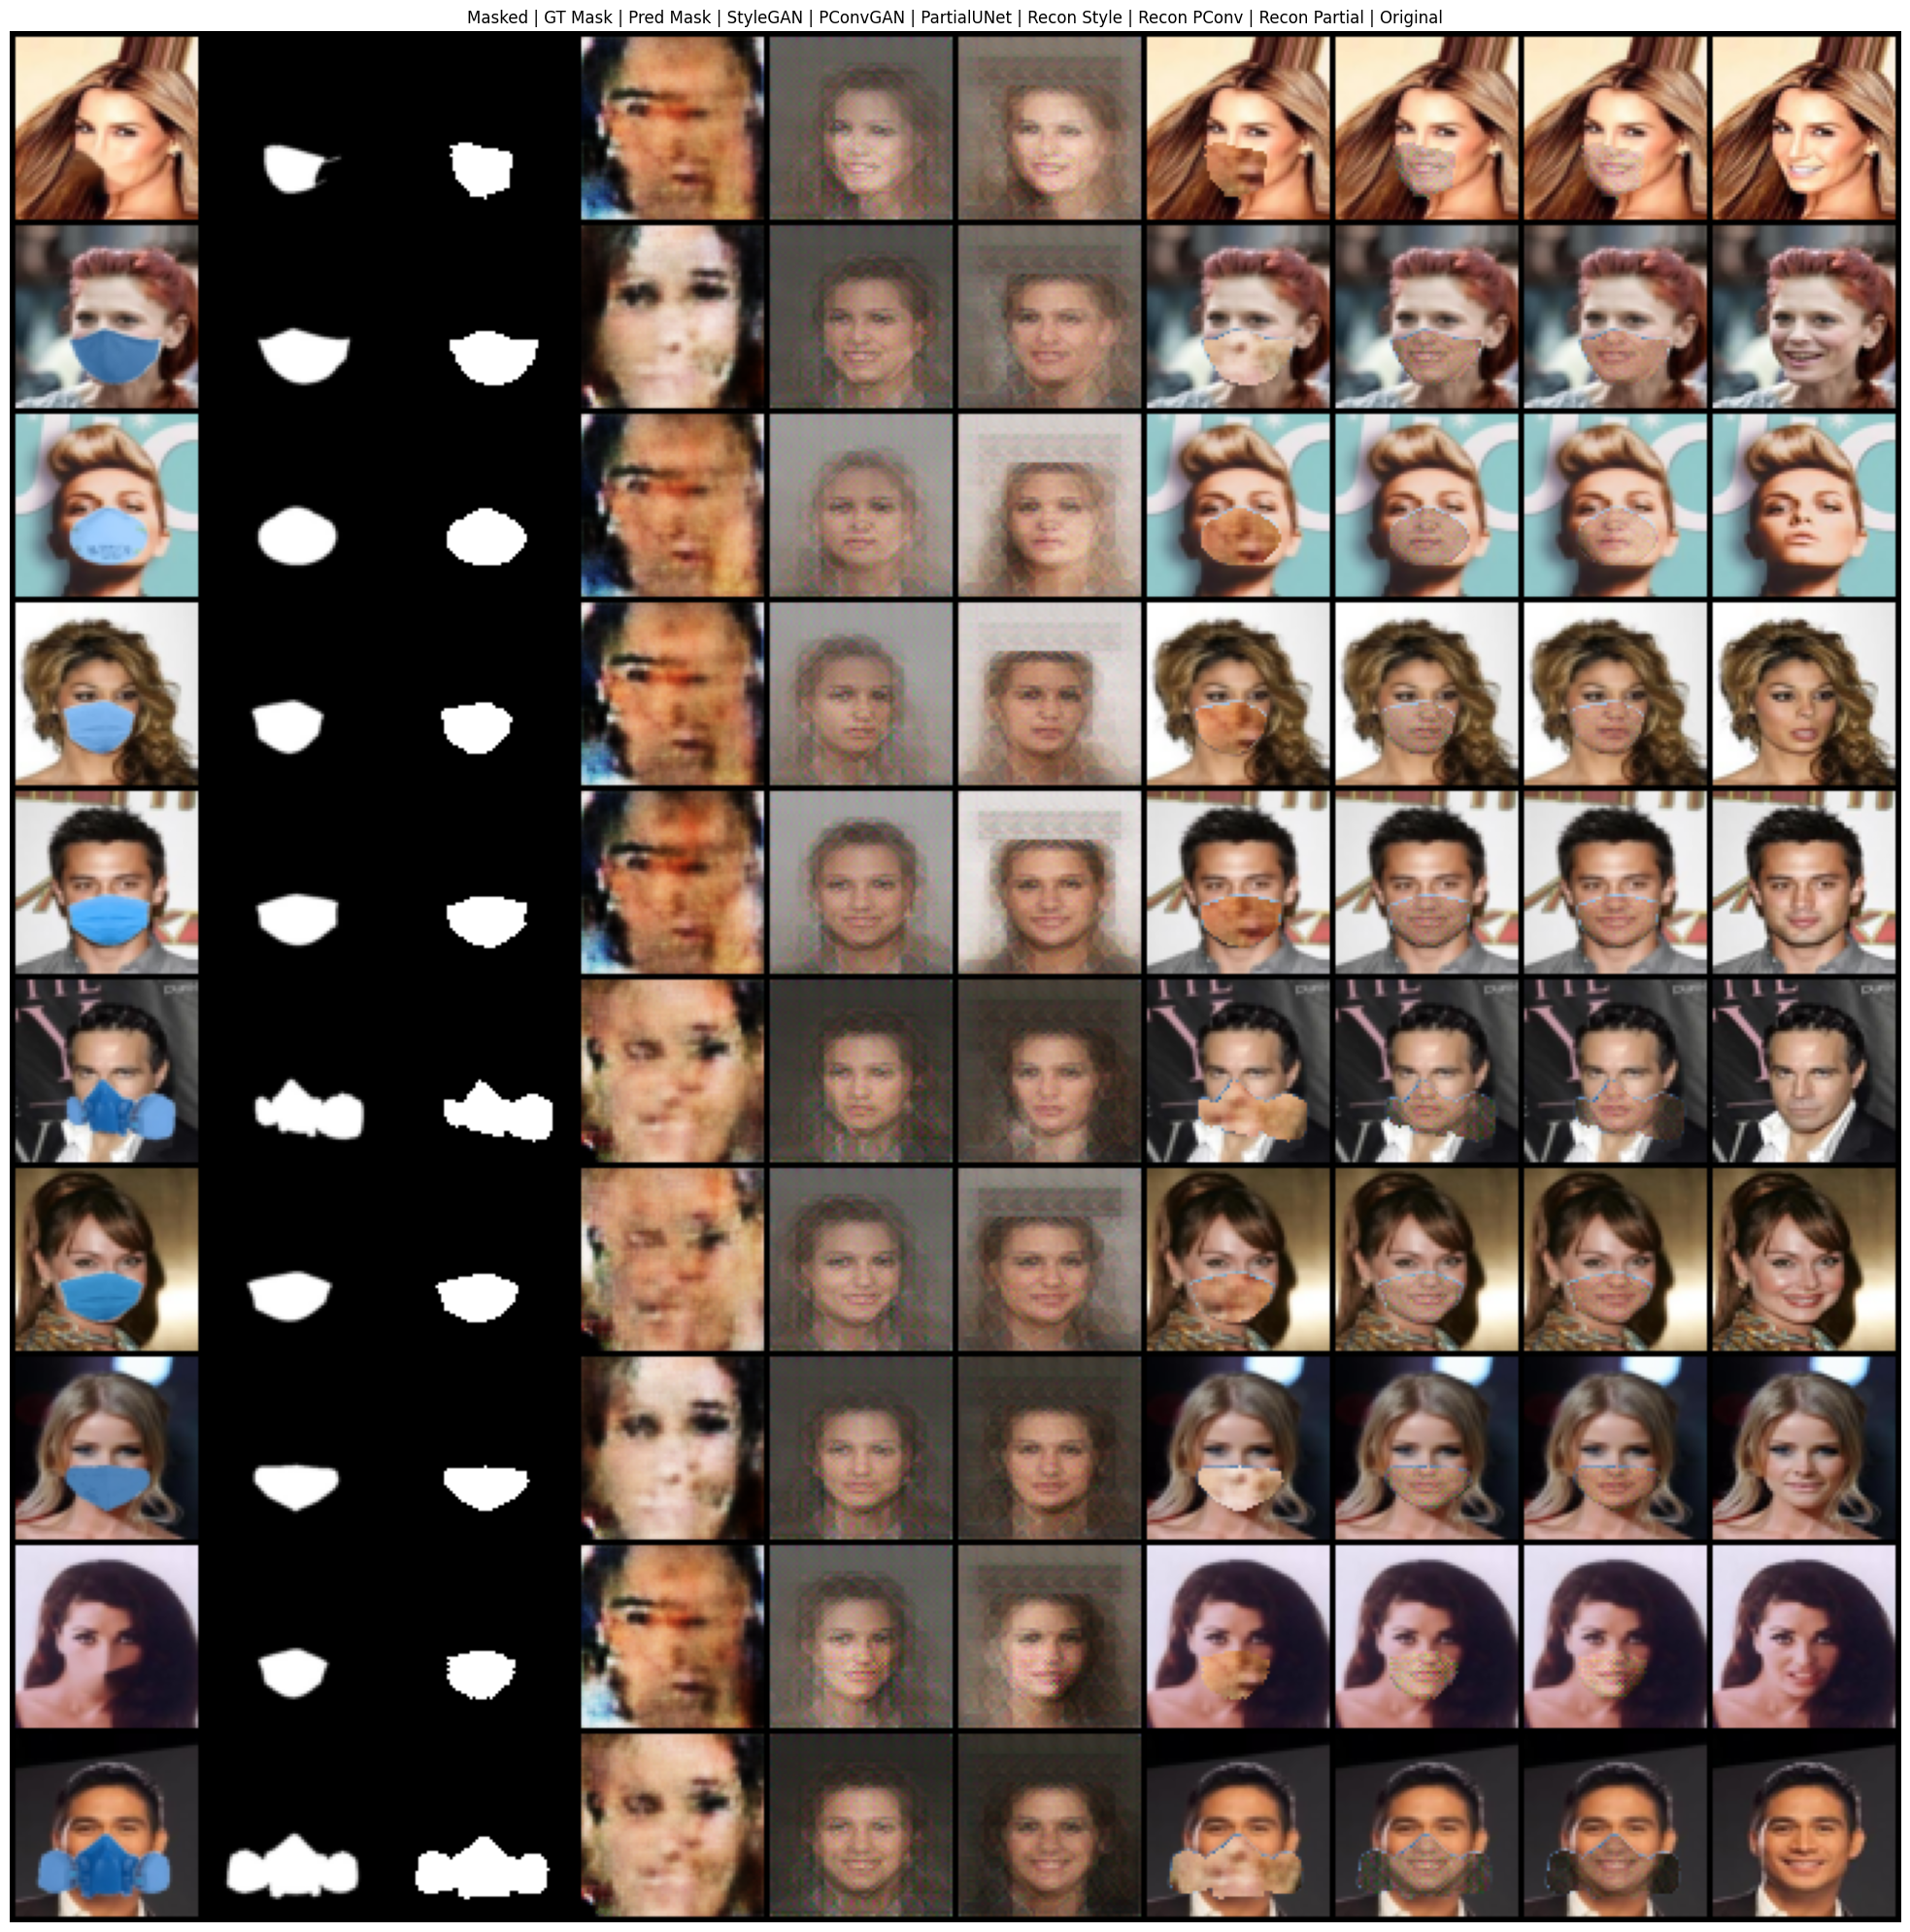

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import cv2
from glob import glob
from tqdm import tqdm
from models import *
import warnings
warnings.filterwarnings('ignore')


# === Device setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Image Transform ===
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

mask_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# === Denormalization ===
def denorm(t): return (t + 1) / 2

# === Load Models ===
mask_predictor = BinaryUNet(in_channels=3, out_channels=1, base_channels=64).to(device)
mask_predictor.load_state_dict(torch.load('binary-mask/best_model.pth', map_location=device)['unet_state_dict'])
mask_predictor.eval()

styleCycleGAN = StyleGANModel().to(device)
styleCycleGAN.load_state_dict(torch.load('style-cycle-gan/best_model.pth', map_location=device))
styleCycleGAN.eval()

pconvunet = PDUNet().to(device)
pconvunet.load_state_dict(torch.load('PConv-Unet/pdunet-outputs/kaggle/working/checkpoints/run3/best_model.pth', map_location=device)['unet_state_dict'])
pconvunet.eval()

partial_unet = PartialUNet(in_channels=3, out_channels=3).to(device)
partial_unet.load_state_dict(torch.load('PConvGAN-model/gan-outputs/checkpoints/run1/best_model.pth', map_location=device)['generator_state_dict'])
partial_unet.eval()

# === Directories ===
masked_dir = "dataset/masked_images"
original_dir = "dataset/original_images"
binary_mask_dir = "dataset/binary_masks"

# === Get paired paths ===
def get_paired_images(num_samples=10):
    masked_images = glob(os.path.join(masked_dir, "*.jpg"))
    masked_images = masked_images[:num_samples]
    pairs = []
    for masked_path in masked_images:
        fname = os.path.basename(masked_path).split("_")[0] + ".jpg"
        original_path = os.path.join(original_dir, fname)
        mask_path = os.path.join(binary_mask_dir, os.path.basename(masked_path).replace(".jpg", "_binary.jpg"))
        if os.path.exists(original_path) and os.path.exists(mask_path):
            pairs.append((masked_path, original_path, mask_path))
    return pairs

paired_images = get_paired_images(num_samples=10)

# === Visualization Grid ===
vis_rows = []

for masked_path, original_path, gt_mask_path in tqdm(paired_images):
    # Load masked image
    masked_img = Image.open(masked_path).convert("RGB")
    masked_tensor = image_transform(masked_img).unsqueeze(0).to(device)

    # Ground Truth Mask
    gt_mask = Image.open(gt_mask_path).convert("L")
    gt_mask_tensor = mask_transform(gt_mask).unsqueeze(0).to(device)

    # Predict Mask
    with torch.no_grad():
        pred_mask = mask_predictor(masked_tensor)
        pred_mask_np = pred_mask[0, 0].cpu().numpy()
        pred_mask_np = (pred_mask_np * 255).astype(np.uint8)
        _, binary_pred_mask = cv2.threshold(pred_mask_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        binary_pred_mask_tensor = torch.tensor(binary_pred_mask).unsqueeze(0).unsqueeze(0).float().to(device) / 255.0

    # Inpaint with all models
    with torch.no_grad():
        style_out = styleCycleGAN.G_masked_unmasked(masked_tensor)
        pconv_out = pconvunet(masked_tensor, binary_pred_mask_tensor)
        partial_out = partial_unet(masked_tensor, binary_pred_mask_tensor)

    # Reconstruct
    mask_3c = binary_pred_mask_tensor.expand_as(masked_tensor)
    recon_style = masked_tensor * (1 - mask_3c) + style_out * mask_3c
    recon_pconv = masked_tensor * (1 - mask_3c) + pconv_out * mask_3c
    recon_partial = masked_tensor * (1 - mask_3c) + partial_out * mask_3c

    # Original
    original_img = Image.open(original_path).convert("RGB").resize((64, 64))
    original_tensor = transforms.ToTensor()(original_img).unsqueeze(0).to(device)
    original_tensor = (original_tensor - 0.5) / 0.5

    # Stack each image variation horizontally to form a row (10 images side-by-side)
    vis_row = torch.stack([
        denorm(masked_tensor[0].cpu()),
        gt_mask_tensor[0].repeat(3, 1, 1).cpu(),
        binary_pred_mask_tensor[0].repeat(3, 1, 1).cpu(),
        denorm(style_out[0].cpu()),
        denorm(pconv_out[0].cpu()),
        denorm(partial_out[0].cpu()),
        denorm(recon_style[0].cpu()),
        denorm(recon_pconv[0].cpu()),
        denorm(recon_partial[0].cpu()),
        denorm(original_tensor[0].cpu())
    ], dim=0)  # (10, 3, 64, 64)

    # Transpose to (10, 3, 64, 64) format
    vis_rows.append(vis_row)



# Concatenate all image rows vertically (each row has shape [10, 3, 64, 64])
vis_tensor = torch.cat(vis_rows, dim=0)  # (10*10, 3, 64, 64)

# Make grid with 10 images per row (each row is 1 input)
final_grid = make_grid(vis_tensor, nrow=10, padding=2)

plt.figure(figsize=(20, 20))
plt.imshow(final_grid.permute(1, 2, 0).numpy())
plt.axis("off")
plt.title("Masked | GT Mask | Pred Mask | StyleGAN | PConvGAN | PartialUNet | Recon Style | Recon PConv | Recon Partial | Original")
plt.tight_layout()
plt.show()


## 🔍 Visual Interpretation of Inpainting Models

Each **row** in the grid corresponds to a different face image.  
Each **column** from left to right shows:
1. Masked Input
2. Ground Truth Binary Mask
3. Predicted Binary Mask
4. StyleCycleGAN Output
5. PConvGAN Output
6. PartialUNet Output
7. Reconstructed Image (StyleCycleGAN)
8. Reconstructed Image (PConvGAN)
9. Reconstructed Image (PartialUNet)
10. Original Unmasked Face

---

### 🧠 Model-wise Observations

---

### ✅ **StyleCycleGAN**

- **Strengths**:
  - Reconstructs global facial structure well.
  - Often produces sharp, vibrant outputs.

- **Weaknesses**:
  - **Identity drift**: Inpainted region sometimes does not match the rest of the face.
  - **Style mismatch**: Inconsistent lighting or textures.
  - Some outputs look overly stylized or cartoonish.


---

### ✅ **PConvGAN**

- **Strengths**:
  - Better **texture consistency** and blending than StyleCycleGAN.
  - Maintains facial structure fairly well.

- **Weaknesses**:
  - Outputs tend to be **blurry**.
  - Lacks fine details (e.g., skin texture).
  - Slight symmetry or artifact issues in occluded areas.


---

### ✅ **PartialUNet**

- **Strengths**:
  - Most **realistic and coherent** outputs.
  - Best **facial identity preservation** and **seamless blending**.
  - Clean reconstructions with structural symmetry.

- **Weaknesses**:
  - Slightly lower sharpness compared to StyleCycleGAN.
  - Sometimes a bit too flat in texture (less noise/detail).


---

### 🔚 **Overall Comparison**

| Model         | Sharpness | Identity Preservation | Texture Matching | Coherence |
|---------------|-----------|------------------------|------------------|-----------|
| StyleCycleGAN | ⭐⭐⭐⭐     | ❌ Often fails         | ⭐⭐               | ⭐⭐       |
| PConvGAN      | ⭐⭐⭐       | ✅ Decent              | ✅ Good           | ⭐⭐⭐⭐     |
| PartialUNet   | ⭐⭐⭐       | ✅ Best                | ✅ Best           | ✅ Best   |

✅ **Conclusion**: If you're prioritizing realism, consistency, and identity preservation — **PartialUNet** is the most effective model among the three for face mask inpainting.


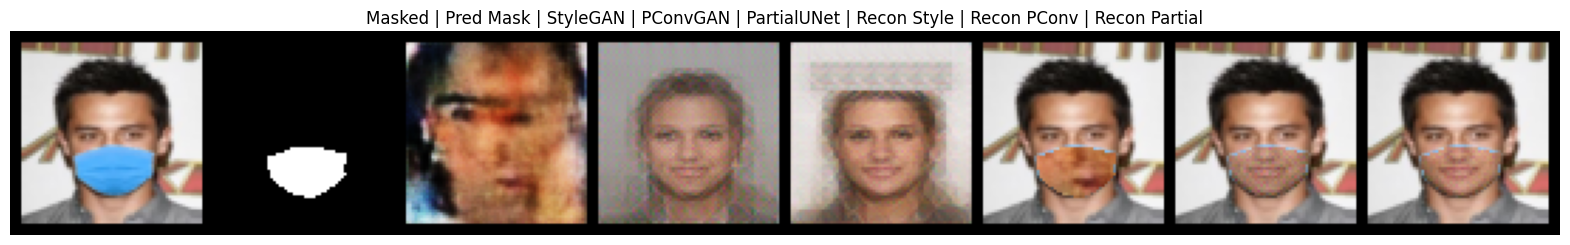

In [ ]:
# === Denormalization ===
def denorm(t): return (t + 1) / 2

# === Load Models ===
mask_predictor = BinaryUNet(in_channels=3, out_channels=1, base_channels=64).to(device)
mask_predictor.load_state_dict(torch.load('binary-mask/best_model.pth', map_location=device)['unet_state_dict'])
mask_predictor.eval()

styleCycleGAN = StyleGANModel().to(device)
styleCycleGAN.load_state_dict(torch.load('style-cycle-gan/best_model.pth', map_location=device))
styleCycleGAN.eval()

pconvunet = PDUNet().to(device)
pconvunet.load_state_dict(torch.load('PConv-Unet/pdunet-outputs/kaggle/working/checkpoints/run3/best_model.pth', map_location=device)['unet_state_dict'])
pconvunet.eval()

partial_unet = PartialUNet(in_channels=3, out_channels=3).to(device)
partial_unet.load_state_dict(torch.load('PConvGAN-model/gan-outputs/checkpoints/run1/best_model.pth', map_location=device)['generator_state_dict'])
partial_unet.eval()

def visualize_inpainting_for_image(masked_image_path):
    import matplotlib.pyplot as plt

    # Load and transform masked image
    masked_img = Image.open(masked_image_path).convert("RGB")
    masked_tensor = image_transform(masked_img).unsqueeze(0).to(device)

    # Predict Binary Mask
    with torch.no_grad():
        pred_mask = mask_predictor(masked_tensor)
        pred_mask_np = pred_mask[0, 0].cpu().numpy()
        pred_mask_np = (pred_mask_np * 255).astype(np.uint8)
        _, binary_pred_mask = cv2.threshold(pred_mask_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        binary_pred_mask_tensor = torch.tensor(binary_pred_mask).unsqueeze(0).unsqueeze(0).float().to(device) / 255.0

    # Inpaint using all models
    with torch.no_grad():
        style_out = styleCycleGAN.G_masked_unmasked(masked_tensor)
        pconv_out = pconvunet(masked_tensor, binary_pred_mask_tensor)
        partial_out = partial_unet(masked_tensor, binary_pred_mask_tensor)

    # Reconstruct blended outputs
    mask_3c = binary_pred_mask_tensor.expand_as(masked_tensor)
    recon_style = masked_tensor * (1 - mask_3c) + style_out * mask_3c
    recon_pconv = masked_tensor * (1 - mask_3c) + pconv_out * mask_3c
    recon_partial = masked_tensor * (1 - mask_3c) + partial_out * mask_3c

    # Denormalize for visualization
    def d(t): return (t + 1) / 2

    # Stack all variants: [masked, pred_mask, style, pconv, partial, recon_*]
    images = torch.stack([
        d(masked_tensor[0].cpu()),  # Masked Input
        binary_pred_mask_tensor[0].repeat(3, 1, 1).cpu(),  # Predicted Mask
        d(style_out[0].cpu()),
        d(pconv_out[0].cpu()),
        d(partial_out[0].cpu()),
        d(recon_style[0].cpu()),
        d(recon_pconv[0].cpu()),
        d(recon_partial[0].cpu()),
    ], dim=0)

    # Make grid
    grid = make_grid(images, nrow=8, padding=4)
    grid_np = grid.permute(1, 2, 0).numpy()

    # Plot
    plt.figure(figsize=(20, 5))
    plt.imshow(grid_np)
    plt.axis("off")
    plt.title("Masked | Pred Mask | StyleGAN | PConvGAN | PartialUNet | Recon Style | Recon PConv | Recon Partial")
    plt.show()



visualize_inpainting_for_image('dataset/masked_images/000007_surgical_blue.jpg')

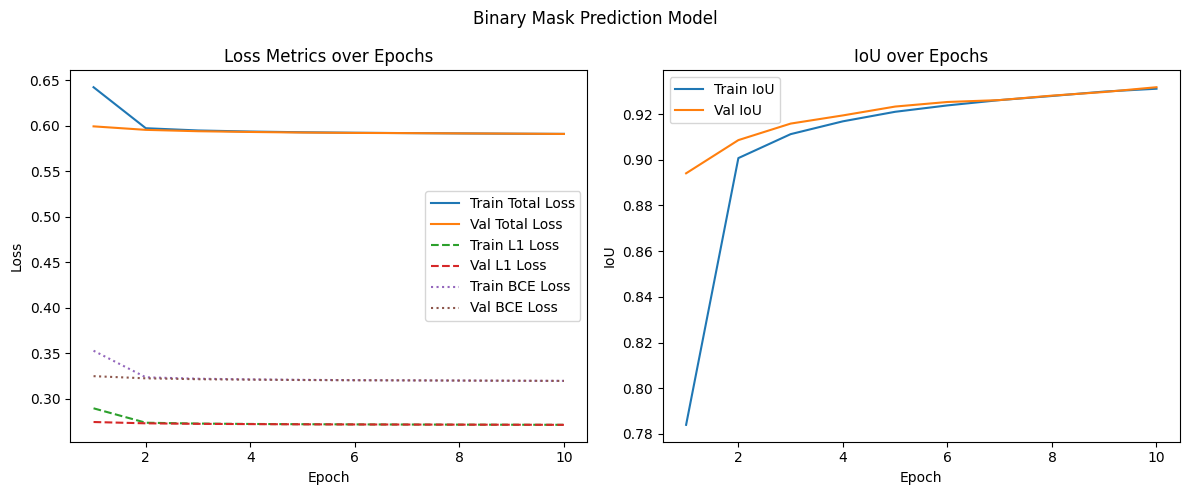

In [3]:
import pandas as pd
# Read CSV
df = pd.read_csv("binary-mask/checkpoints_segmentation/training_log.csv")

# Plot Losses
plt.figure(figsize=(12, 5))
plt.suptitle("Binary Mask Prediction Model")
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_total_loss'], label='Train Total Loss')
plt.plot(df['epoch'], df['val_total_loss'], label='Val Total Loss')
plt.plot(df['epoch'], df['train_l1_loss'], label='Train L1 Loss', linestyle='--')
plt.plot(df['epoch'], df['val_l1_loss'], label='Val L1 Loss', linestyle='--')
plt.plot(df['epoch'], df['train_bce_loss'], label='Train BCE Loss', linestyle=':')
plt.plot(df['epoch'], df['val_bce_loss'], label='Val BCE Loss', linestyle=':')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Metrics over Epochs")
plt.legend()

# Plot IOU
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_iou'], label='Train IoU')
plt.plot(df['epoch'], df['val_iou'], label='Val IoU')
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("IoU over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


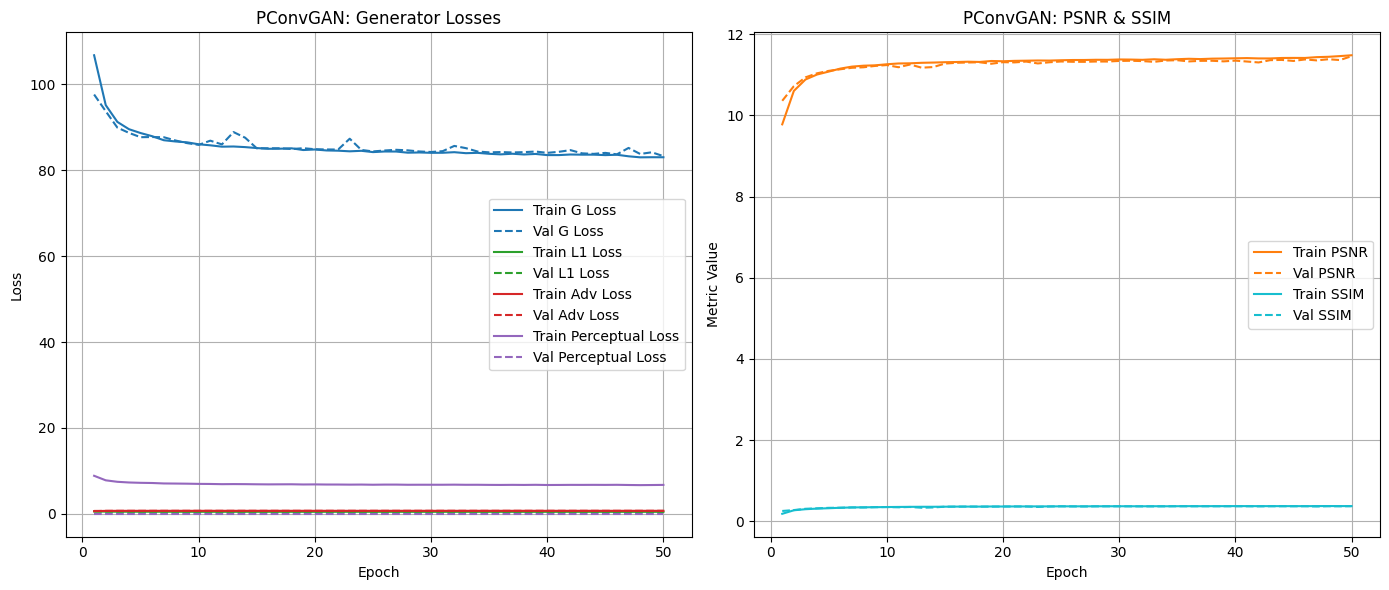

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load CSVs ===
pconvgan_df = pd.read_csv("PConvGAN-model/checkpoints/run1/training_log.csv")
pconvunet_df = pd.read_csv("PConv-Unet/checkpoints/training_log.csv")

# === Plot Losses and Metrics for PConvGAN ===
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(pconvgan_df['epoch'], pconvgan_df['train_g_loss'], label='Train G Loss', color='tab:blue')
plt.plot(pconvgan_df['epoch'], pconvgan_df['val_g_loss'], label='Val G Loss', color='tab:blue', linestyle='--')
plt.plot(pconvgan_df['epoch'], pconvgan_df['train_g_l1_loss'], label='Train L1 Loss', color='tab:green')
plt.plot(pconvgan_df['epoch'], pconvgan_df['val_g_l1_loss'], label='Val L1 Loss', color='tab:green', linestyle='--')
plt.plot(pconvgan_df['epoch'], pconvgan_df['train_g_adv_loss'], label='Train Adv Loss', color='tab:red')
plt.plot(pconvgan_df['epoch'], pconvgan_df['val_g_adv_loss'], label='Val Adv Loss', color='tab:red', linestyle='--')
plt.plot(pconvgan_df['epoch'], pconvgan_df['train_g_perceptual_loss'], label='Train Perceptual Loss', color='tab:purple')
plt.plot(pconvgan_df['epoch'], pconvgan_df['val_g_perceptual_loss'], label='Val Perceptual Loss', color='tab:purple', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PConvGAN: Generator Losses")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(pconvgan_df['epoch'], pconvgan_df['train_psnr'], label='Train PSNR', color='tab:orange')
plt.plot(pconvgan_df['epoch'], pconvgan_df['val_psnr'], label='Val PSNR', color='tab:orange', linestyle='--')
plt.plot(pconvgan_df['epoch'], pconvgan_df['train_ssim'], label='Train SSIM', color='tab:cyan')
plt.plot(pconvgan_df['epoch'], pconvgan_df['val_ssim'], label='Val SSIM', color='tab:cyan', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("PConvGAN: PSNR & SSIM")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Plot Losses and Metrics for PConv-UNet ===
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(pconvunet_df['epoch'], pconvunet_df['train_total_loss'], label='Train Total Loss', color='tab:blue')
plt.plot(pconvunet_df['epoch'], pconvunet_df['val_total_loss'], label='Val Total Loss', color='tab:blue', linestyle='--')
plt.plot(pconvunet_df['epoch'], pconvunet_df['train_l1_loss'], label='Train L1 Loss', color='tab:green')
plt.plot(pconvunet_df['epoch'], pconvunet_df['val_l1_loss'], label='Val L1 Loss', color='tab:green', linestyle='--')
plt.plot(pconvunet_df['epoch'], pconvunet_df['train_perceptual_loss'], label='Train Perceptual Loss', color='tab:purple')
plt.plot(pconvunet_df['epoch'], pconvunet_df['val_perceptual_loss'], label='Val Perceptual Loss', color='tab:purple', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PConv-UNet: Losses")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(pconvunet_df['epoch'], pconvunet_df['train_psnr'], label='Train PSNR', color='tab:orange')
plt.plot(pconvunet_df['epoch'], pconvunet_df['val_psnr'], label='Val PSNR', color='tab:orange', linestyle='--')
plt.plot(pconvunet_df['epoch'], pconvunet_df['train_ssim'], label='Train SSIM', color='tab:cyan')
plt.plot(pconvunet_df['epoch'], pconvunet_df['val_ssim'], label='Val SSIM', color='tab:cyan', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("PConv-UNet: PSNR & SSIM")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
